# 🔎 Compare PSO analysis runs 👀

Given a directory containing the output of several PSO analysis runs and the considered IDs, visualise all the plots to compare the results and see how much non-determinism is present (if any). Also load the gene list selected by the PSO (.txt) and compute the gene covariance (if there is any difference between them).

## RESULT: PSO seems to be deterministic

**Author:** Prisca Dotti

**Last modified:** 11.09.2025

In [13]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import mmread
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import jaccard_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Please specify the directory containing the PSO analysis runs and the list of considered IDs.
# Example usage:
analysis_dir = os.path.join("..", "bulk_analysis_output")
considered_ids = ["250827_095606", "250829_110236", "250901_212046"]

In [4]:
# List all subdirectories in the analysis_dir that match the considered IDs
run_dirs = [os.path.join(analysis_dir, f"{run_id}_data") for run_id in considered_ids if os.path.isdir(
    os.path.join(analysis_dir, f"{run_id}_data"))]
print("Found run directories:", run_dirs)

Found run directories: ['../bulk_analysis_output/250827_095606_data', '../bulk_analysis_output/250829_110236_data', '../bulk_analysis_output/250901_212046_data']


In [5]:
# Load the gene list selected by PSO for each run and compute covariance if possible
gene_lists = []
for run_dir in run_dirs:
    gene_list_path = os.path.join(run_dir, "pso_selected_genes.txt")
    if os.path.isfile(gene_list_path):
        with open(gene_list_path, "r") as f:
            genes = [line.strip() for line in f if line.strip()]
            gene_lists.append(genes)
    else:
        print(f"Gene list not found for {run_dir}")

# Find common genes across all runs
if gene_lists:
    common_genes = set(gene_lists[0])
    for genes in gene_lists[1:]:
        common_genes &= set(genes)
    print(f"Common genes across all runs: {len(common_genes)} genes")
    print(f"Number of common genes: {len(common_genes)}")
    for i, genes in enumerate(gene_lists):
        print(f"Run {i+1}: {len(genes)} genes found")
else:
    print("No gene lists found!")
    common_genes = set()

Common genes across all runs: 901 genes
Number of common genes: 901
Run 1: 901 genes found
Run 2: 901 genes found
Run 3: 901 genes found


In [6]:
# Load count matrix (gene expression data)
count_matrix_dir = os.path.join("..", "..", "bulk_data")
count_matrix_path = os.path.join(count_matrix_dir, "count_matrix.mtx")
count_matrix = mmread(count_matrix_path)
print("Loaded count matrix with shape:", count_matrix.shape)
print("Matrix format:", type(count_matrix))

Loaded count matrix with shape: (11528, 831)
Matrix format: <class 'scipy.sparse._coo.coo_matrix'>


In [7]:
# Load gene names and sample names if available
gene_names_path = os.path.join(count_matrix_dir, "gene_names.txt")
sample_names_path = os.path.join(count_matrix_dir, "sample_names.txt")

gene_names = None
sample_names = None

if os.path.exists(gene_names_path):
    with open(gene_names_path, 'r') as f:
        gene_names = [line.strip() for line in f if line.strip()]
    print(f"Loaded {len(gene_names)} gene names")
else:
    print("Gene names file not found, using indices")
    gene_names = [f"Gene_{i}" for i in range(count_matrix.shape[0])]

if os.path.exists(sample_names_path):
    with open(sample_names_path, 'r') as f:
        sample_names = [line.strip() for line in f if line.strip()]
    print(f"Loaded {len(sample_names)} sample names")
else:
    print("Sample names file not found, using indices")
    sample_names = [f"Sample_{i}" for i in range(count_matrix.shape[1])]

Loaded 11528 gene names
Loaded 831 sample names


In [8]:
# Convert to DataFrame for easier manipulation
# Note: Be careful with memory usage for large matrices
print("Converting to DataFrame...")
try:
    # Convert sparse matrix to dense if it's sparse
    if hasattr(count_matrix, 'toarray'):
        dense_matrix = count_matrix.toarray()
    else:
        dense_matrix = count_matrix

    # Create DataFrame with gene names as index and sample names as columns
    expr_df = pd.DataFrame(
        dense_matrix,
        index=gene_names[:count_matrix.shape[0]],
        columns=sample_names[:count_matrix.shape[1]]
    )
    print(f"Expression DataFrame created with shape: {expr_df.shape}")

except MemoryError:
    print("Memory error: Matrix too large to convert to DataFrame. Will work with sparse matrix.")
    expr_df = None

Converting to DataFrame...
Expression DataFrame created with shape: (11528, 831)


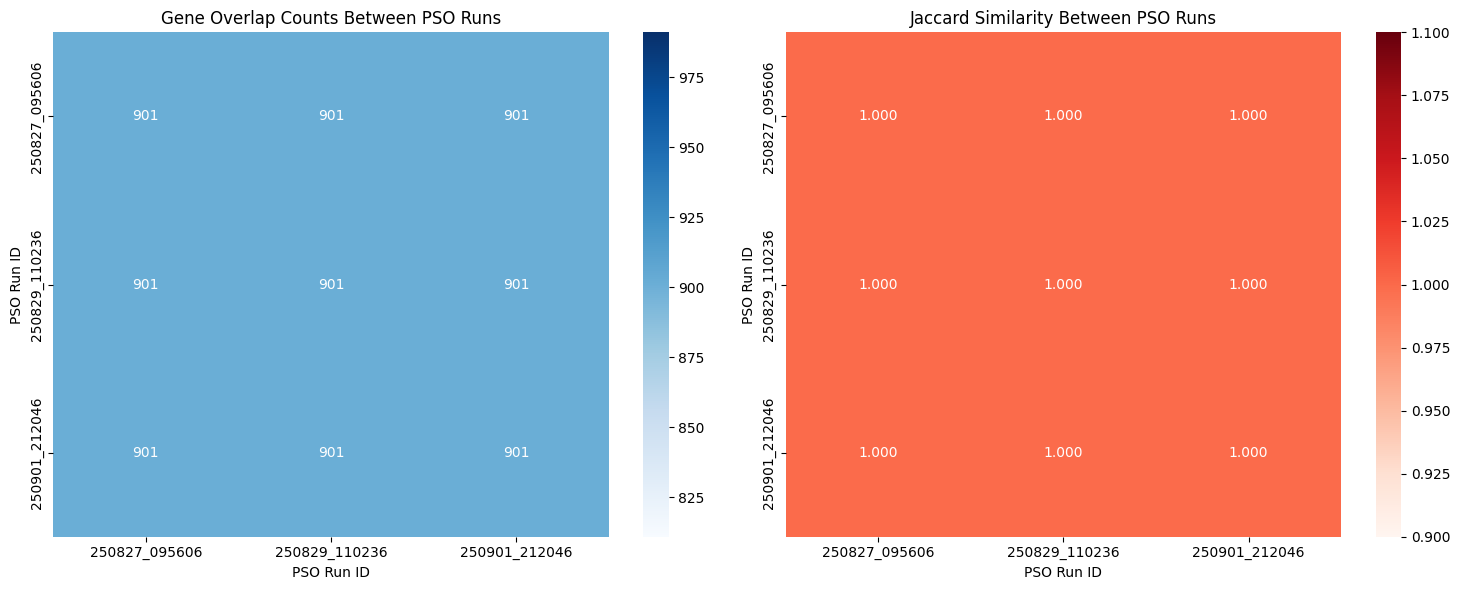


=== Gene Selection Consistency Analysis ===
Average Jaccard similarity: 1.000
Min Jaccard similarity: 1.000
Max Jaccard similarity: 1.000


In [9]:
# Gene overlap analysis between PSO runs
def analyze_gene_overlap(gene_lists, run_ids):
    """Analyze overlap between gene lists from different PSO runs"""
    n_runs = len(gene_lists)

    # Create overlap matrix
    overlap_matrix = np.zeros((n_runs, n_runs))
    jaccard_matrix = np.zeros((n_runs, n_runs))

    for i in range(n_runs):
        for j in range(n_runs):
            set_i = set(gene_lists[i])
            set_j = set(gene_lists[j])

            intersection = len(set_i & set_j)
            union = len(set_i | set_j)

            overlap_matrix[i, j] = intersection
            jaccard_matrix[i, j] = intersection / union if union > 0 else 0

    return overlap_matrix, jaccard_matrix


if gene_lists and len(gene_lists) > 1:
    overlap_mat, jaccard_mat = analyze_gene_overlap(gene_lists, considered_ids)

    # Plot overlap matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Overlap counts
    sns.heatmap(overlap_mat, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=considered_ids, yticklabels=considered_ids, ax=ax1)
    ax1.set_title('Gene Overlap Counts Between PSO Runs')
    ax1.set_xlabel('PSO Run ID')
    ax1.set_ylabel('PSO Run ID')

    # Jaccard similarity
    sns.heatmap(jaccard_mat, annot=True, fmt='.3f', cmap='Reds',
                xticklabels=considered_ids, yticklabels=considered_ids, ax=ax2)
    ax2.set_title('Jaccard Similarity Between PSO Runs')
    ax2.set_xlabel('PSO Run ID')
    ax2.set_ylabel('PSO Run ID')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n=== Gene Selection Consistency Analysis ===")
    print(
        f"Average Jaccard similarity: {np.mean(jaccard_mat[np.triu_indices_from(jaccard_mat, k=1)]):.3f}")
    print(
        f"Min Jaccard similarity: {np.min(jaccard_mat[np.triu_indices_from(jaccard_mat, k=1)]):.3f}")
    print(
        f"Max Jaccard similarity: {np.max(jaccard_mat[np.triu_indices_from(jaccard_mat, k=1)]):.3f}")

In [10]:
# Gene covariance analysis for selected genes
def compute_gene_covariance_analysis(expr_df, gene_lists, run_ids):
    """Compute and compare gene covariance for selected genes from each PSO run"""

    if expr_df is None:
        print("Cannot compute covariance: Expression DataFrame not available")
        return None

    covariance_results = {}

    for i, (genes, run_id) in enumerate(zip(gene_lists, run_ids)):
        # Find genes that exist in the expression data
        available_genes = [g for g in genes if g in expr_df.index]
        missing_genes = set(genes) - set(available_genes)

        print(f"\nRun {run_id}:")
        print(f"  - Requested genes: {len(genes)}")
        print(f"  - Available genes: {len(available_genes)}")
        print(f"  - Missing genes: {len(missing_genes)}")

        if len(available_genes) > 1:
            # Subset expression data to selected genes
            subset_expr = expr_df.loc[available_genes]

            # Compute gene-gene covariance matrix
            gene_cov = subset_expr.cov()

            # Store results
            covariance_results[run_id] = {
                'genes': available_genes,
                'covariance_matrix': gene_cov,
                'mean_covariance': np.mean(gene_cov.values[np.triu_indices_from(gene_cov, k=1)]),
                'std_covariance': np.std(gene_cov.values[np.triu_indices_from(gene_cov, k=1)])
            }
        else:
            print(f"  - Not enough genes for covariance analysis")

    return covariance_results


if gene_lists and expr_df is not None:
    cov_results = compute_gene_covariance_analysis(
        expr_df, gene_lists, considered_ids)

    if cov_results:
        # Compare covariance statistics
        print("\n=== Gene Covariance Comparison ===")
        for run_id, results in cov_results.items():
            print(f"{run_id}: Mean cov = {results['mean_covariance']:.4f}, "
                  f"Std cov = {results['std_covariance']:.4f}")


Run 250827_095606:
  - Requested genes: 901
  - Available genes: 901
  - Missing genes: 0

Run 250829_110236:
  - Requested genes: 901
  - Available genes: 901
  - Missing genes: 0

Run 250901_212046:
  - Requested genes: 901
  - Available genes: 901
  - Missing genes: 0

=== Gene Covariance Comparison ===
250827_095606: Mean cov = 164390127.2297, Std cov = 2584192377.2037
250829_110236: Mean cov = 164390127.2297, Std cov = 2584192377.2037
250901_212046: Mean cov = 164390127.2297, Std cov = 2584192377.2037


Visualizing expression patterns for 901 common genes


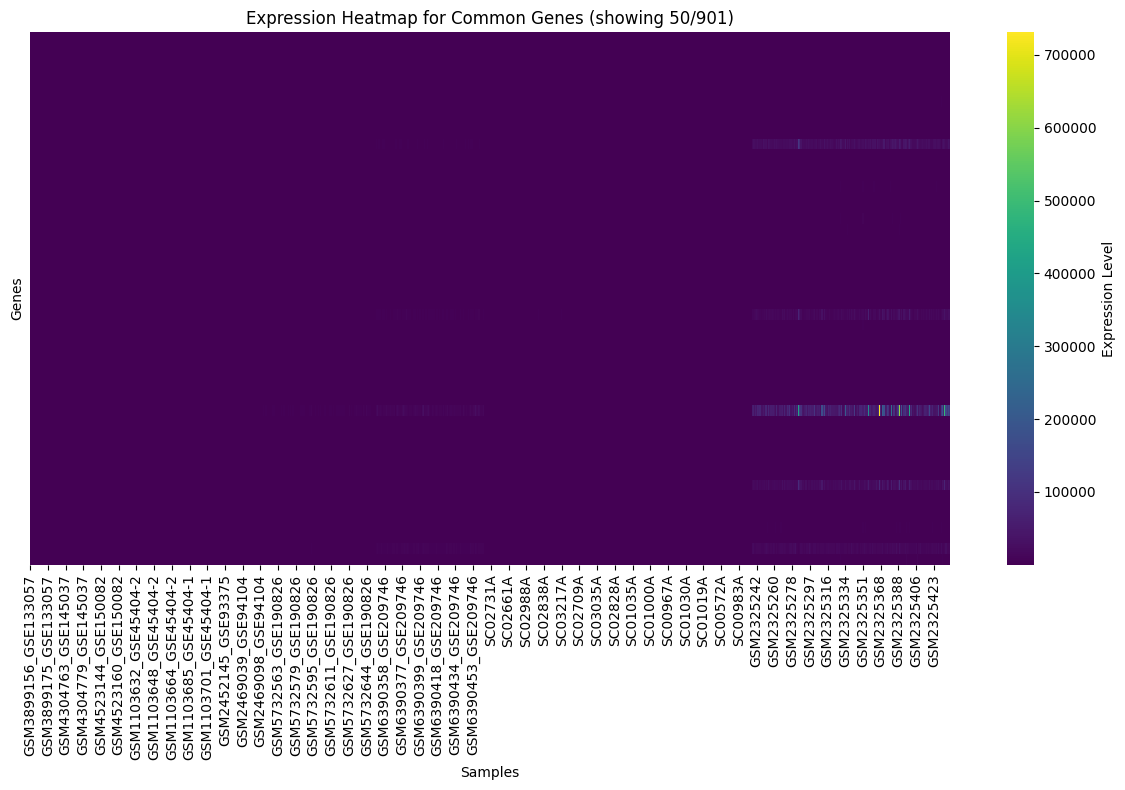

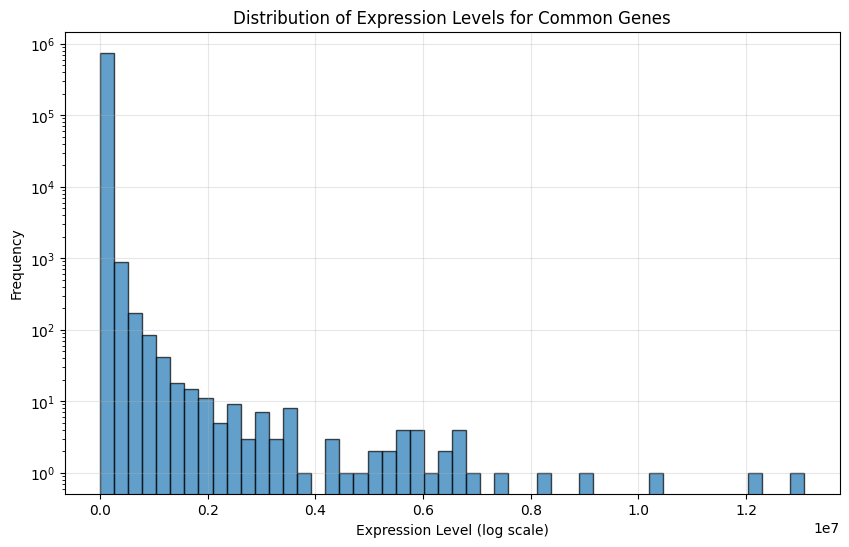

In [11]:
# Visualize gene expression patterns for common genes
if expr_df is not None and len(common_genes) > 0:
    # Get expression data for common genes
    common_genes_available = [g for g in common_genes if g in expr_df.index]

    if len(common_genes_available) > 0:
        print(
            f"Visualizing expression patterns for {len(common_genes_available)} common genes")

        # Create heatmap of common gene expressions
        common_expr = expr_df.loc[common_genes_available]

        # Plot heatmap (limit to reasonable number of genes for visualization)
        max_genes_plot = min(50, len(common_genes_available))

        plt.figure(figsize=(12, 8))
        sns.heatmap(
            common_expr.iloc[:max_genes_plot],
            cmap='viridis',
            cbar_kws={'label': 'Expression Level'},
            yticklabels=True if max_genes_plot <= 20 else False
        )
        plt.title(
            f'Expression Heatmap for Common Genes (showing {max_genes_plot}/{len(common_genes_available)})')
        plt.xlabel('Samples')
        plt.ylabel('Genes')
        plt.tight_layout()
        plt.show()

        # Plot expression distribution
        plt.figure(figsize=(10, 6))
        common_expr_flat = common_expr.values.flatten()
        plt.hist(common_expr_flat[common_expr_flat > 0],
                 bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Expression Level (log scale)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Expression Levels for Common Genes')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        plt.show()

In [12]:
# Summary statistics and final comparison
def print_summary_statistics(gene_lists, considered_ids, cov_results):
    """Print comprehensive summary of the PSO run comparison"""

    print("\n" + "="*60)
    print("FINAL SUMMARY: PSO RUN COMPARISON")
    print("="*60)

    if gene_lists:
        print(f"\nGene Selection Summary:")
        print(f"  Number of PSO runs: {len(gene_lists)}")

        gene_counts = [len(genes) for genes in gene_lists]
        print(f"  Gene count range: {min(gene_counts)} - {max(gene_counts)}")
        print(f"  Average genes per run: {np.mean(gene_counts):.1f}")
        print(f"  Common genes across all runs: {len(common_genes)}")

        if len(gene_lists) > 1:
            # Calculate pairwise similarities
            all_genes = set()
            for genes in gene_lists:
                all_genes.update(genes)

            print(f"  Total unique genes selected: {len(all_genes)}")
            print(
                f"  Gene selection consistency: {len(common_genes)/len(all_genes):.3f}")

    if cov_results:
        print(f"\nCovariance Analysis:")
        mean_covs = [r['mean_covariance'] for r in cov_results.values()]
        print(
            f"  Mean covariance range: {min(mean_covs):.4f} - {max(mean_covs):.4f}")
        print(f"  Covariance variability: {np.std(mean_covs):.4f}")

    print(f"\nNon-determinism Assessment:")
    if len(gene_lists) > 1 and len(common_genes) > 0:
        consistency_score = len(common_genes) / \
            np.mean([len(genes) for genes in gene_lists])
        if consistency_score > 0.8:
            print("  ✅ HIGH consistency - Low non-determinism")
        elif consistency_score > 0.5:
            print("  ⚠️  MODERATE consistency - Some non-determinism")
        else:
            print("  ❌ LOW consistency - High non-determinism")
    else:
        print("  ❓ Cannot assess - Insufficient data")


# Print final summary
if gene_lists:
    print_summary_statistics(gene_lists, considered_ids,
                             cov_results if 'cov_results' in locals() else None)


FINAL SUMMARY: PSO RUN COMPARISON

Gene Selection Summary:
  Number of PSO runs: 3
  Gene count range: 901 - 901
  Average genes per run: 901.0
  Common genes across all runs: 901
  Total unique genes selected: 901
  Gene selection consistency: 1.000

Covariance Analysis:
  Mean covariance range: 164390127.2297 - 164390127.2297
  Covariance variability: 0.0000

Non-determinism Assessment:
  ✅ HIGH consistency - Low non-determinism
